In [1]:
import cv2
import hyperopt
import hyperopt.pyll.stochastic
from hyperopt import Trials, fmin, hp, space_eval, tpe

from ocr import cummulative_dissimilarity, dissimilarity
from plotting import plot_losses_history
from utils import hprange

Let's define the search space:

In [2]:
search_space = {
    "resize": hprange("resize", 50, 200),
    "binarize": hp.choice(
        "binarize",
        [
            (
                True,
                (
                    hp.choice(
                        "binarize_algorithm",
                        [cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.ADAPTIVE_THRESH_MEAN_C],
                    ),
                    hprange("binarize_blocksize", 13, 29, 2),
                    hprange("binarize_c", 7, 15),
                ),
                {
                    "dilate": hp.choice(
                        "dilate", [(True, hprange("dilate_kernel", 1, 4, 2)), (False,)]
                    ),
                    "erode": hp.choice(
                        "erode", [(True, hprange("erode_kernel", 1, 4, 2)), (False,)]
                    ),
                },
            ),
            (False,),
        ],
    ),
    "denoise": hp.choice(
        "denoise",
        [
            (
                True,
                (
                    hprange("denoise_h", 1, 10, 2),
                    hprange("denoise_windowsize", 13, 27, 2),
                    hprange("denoise_blocksize", 5, 15, 2),
                ),
            ),
            (False,),
        ],
    ),
}

We can check some example values by sampling from the space a couple of times:

In [3]:
for _ in range(5):
    print(hyperopt.pyll.stochastic.sample(search_space))

{'binarize': (True, (0, 19, 14), {'dilate': (False,), 'erode': (False,)}), 'denoise': (False,), 'resize': 122}
{'binarize': (True, (0, 25, 9), {'dilate': (True, 1), 'erode': (True, 3)}), 'denoise': (False,), 'resize': 152}
{'binarize': (False,), 'denoise': (False,), 'resize': 183}
{'binarize': (True, (1, 15, 7), {'dilate': (True, 1), 'erode': (True, 1)}), 'denoise': (False,), 'resize': 184}
{'binarize': (False,), 'denoise': (False,), 'resize': 147}


The impact of different values on the output can be seen below:

{'binarize': (False,), 'denoise': (False,), 'resize': 127}


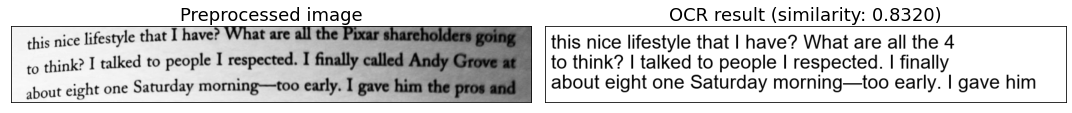

{'binarize': (True, (0, 19, 13), {'dilate': (False,), 'erode': (True, 3)}), 'denoise': (False,), 'resize': 100}


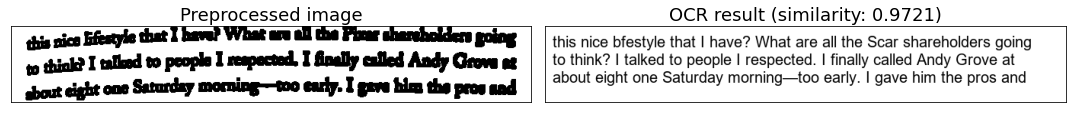

In [5]:
for _ in range(2):
    params = hyperopt.pyll.stochastic.sample(search_space)
    print(params)
    dissimilarity('data/images/3.jpg', 'data/texts/3.txt', params, display=True)

Finally, let's run the Hyperopt optimization over 1000 samples:

In [6]:
trials = Trials()
best = fmin(
    cummulative_dissimilarity,
    search_space,
    algo=tpe.suggest,
    max_evals=4000,
    trials=trials,
)

100%|██████████| 4000/4000 [3:03:59<00:00,  2.76s/trial, best loss: 0.2637919640168027]  


The losses in individual iterations are plotted below. The data is pretty noisy, so in order to see the overall trend, we fit a linear regressor to the data and display it in red. It can be seen that the average loss gets lower over time. If the algorithm was completely random, we would expect a horizontal line:

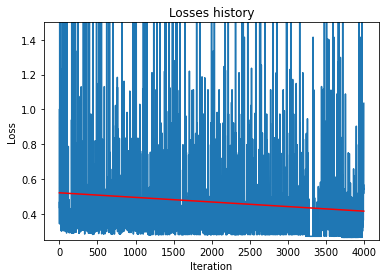

In [13]:
plot_losses_history(trials.results, (0.25, 1.5))


Results for the best parameters found can be seen below:

{'binarize': (True, (0, 27, 8), {'dilate': (True, 1), 'erode': (False,)}), 'denoise': (False,), 'resize': 181}


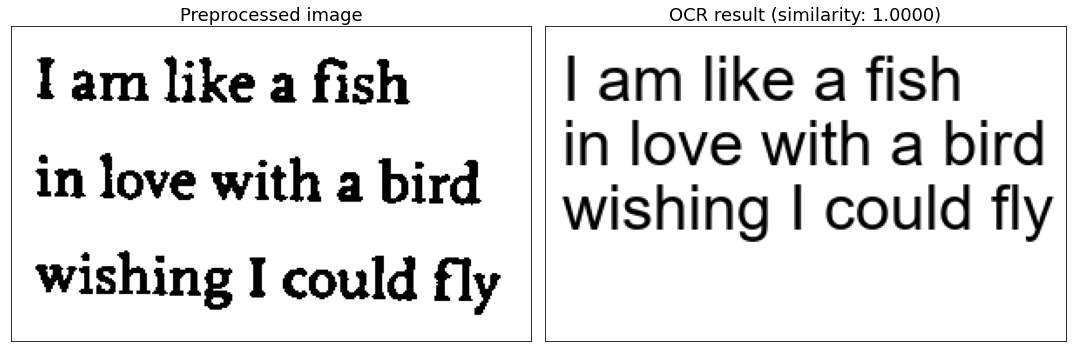

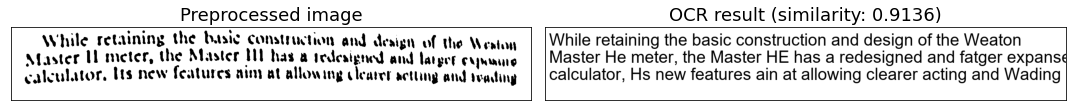

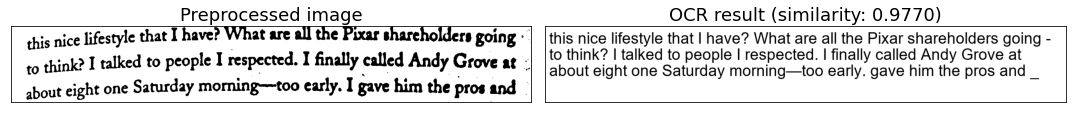

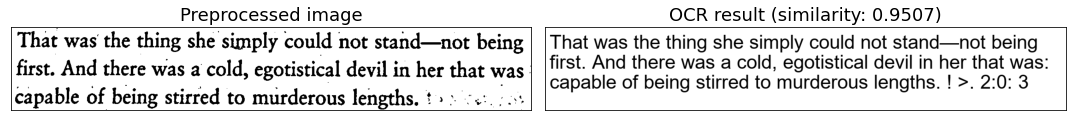

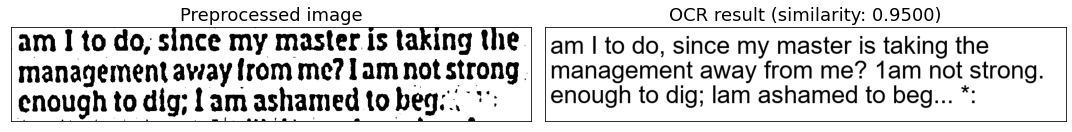

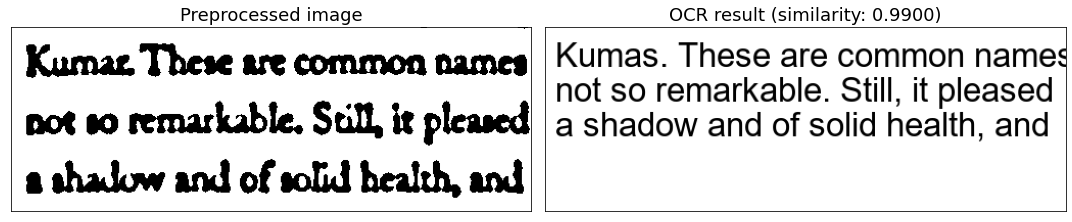

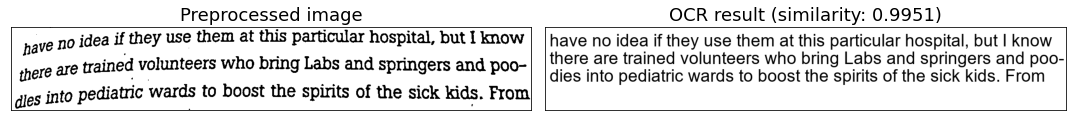

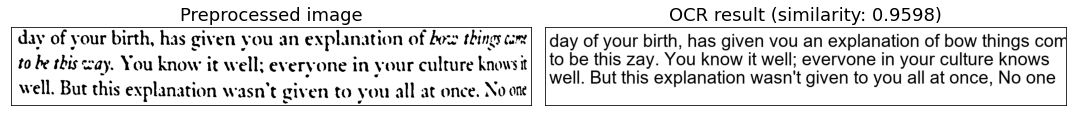

{'loss': 0.2637919640168027,
 'status': 'ok',
 'params': {'binarize': (True,
   (0, 27, 8),
   {'dilate': (True, 1), 'erode': (False,)}),
  'denoise': (False,),
  'resize': 181}}

In [14]:
params = space_eval(search_space, best)
print(params)
cummulative_dissimilarity2(params, display=True)